# Severstal Steel Defect Detection
#### Problem Statement:
The objective of this project is to predict the location and type of defects found in steel manufacturing using the images provided. The images are named with a unique ImageId, and our task is to segment each image and classify the defects in the test set.


This notebook contain EDA, Segmentation and Data agumentation Part 

In [1]:
# Using segmentation_models for image segmentation task, https://github.com/qubvel/segmentation_models
#! pip install segmentation-models

In [30]:
## import lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
from datetime import datetime

import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from sklearn.metrics import recall_score
from random import random
from random import seed

import segmentation_models
print(segmentation_models.__version__)

import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from tensorflow.keras.utils import plot_model

1.0.1


In [2]:
from tensorflow import keras
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

C:\Users\sonali\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\sonali\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\sonali\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be 

##### Load the Data 

In [3]:
df = pd.read_csv('C:/Users/sonali/Desktop/DS/Semester_4/DLproject/severstal-steel-defect-detection/train.csv')
df.shape

(7095, 3)

In [4]:
df.head()

ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...

##### Data Preparation:
Available data is not in the X_train, Y_train format, we need to generate these with the help of getting image names from train_images folder and merging these with train.csv 

In [5]:
from glob import glob
# set paths to train and test image datasets
TRAIN_PATH = 'C:/Users/sonali/Desktop/DS/Semester_4/DLproject/severstal-steel-defect-detection/train_images/'
TEST_PATH = 'C:/Users/sonali/Desktop/DS/Semester_4/DLproject/severstal-steel-defect-detection/test_images/'

# load dataframe with train labels
train_fns = sorted(glob(TRAIN_PATH + '*.jpg'))
test_fns = sorted(glob(TEST_PATH + '*.jpg'))

print('There are {} images in the train set.'.format(len(train_fns)))
print('There are {} images in the test set.'.format(len(test_fns)))

There are 12568 images in the train set.
There are 5506 images in the test set.


So total there are 12568 train images and 5506 test images

In [6]:
train_image_names = os.listdir(TRAIN_PATH)
test_image_names = os.listdir(TEST_PATH)

train_image_names[:5]

['0002cc93b.jpg',
 '00031f466.jpg',
 '000418bfc.jpg',
 '000789191.jpg',
 '0007a71bf.jpg']

append the class id to images 

In [7]:
tr_img_id = []
tr_cls_id = []
for i in os.listdir(TRAIN_PATH):
    tr_img_id.append(i)
    tr_cls_id.append(1)
    tr_img_id.append(i)
    tr_cls_id.append(2)
    tr_img_id.append(i)
    tr_cls_id.append(3)
    tr_img_id.append(i)
    tr_cls_id.append(4)
train_img_nms = pd.DataFrame(tr_img_id,columns=['ImageId'])
train_img_nms['ClassId'] = tr_cls_id
train_img_nms.head()

ImageId  ClassId
0  0002cc93b.jpg        1
1  0002cc93b.jpg        2
2  0002cc93b.jpg        3
3  0002cc93b.jpg        4
4  00031f466.jpg        1

In [8]:
train_df = pd.merge(train_img_nms, df,how='outer',on=['ImageId','ClassId'])
train_df = train_df.fillna('')
train_df.head()

ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0002cc93b.jpg        2                                                   
2  0002cc93b.jpg        3                                                   
3  0002cc93b.jpg        4                                                   
4  00031f466.jpg        1

Labels are in encoded pixels which need to the masked using run length encoder

In [9]:
train_data = pd.pivot_table(train_df, values='EncodedPixels', index='ImageId',columns='ClassId', aggfunc=np.sum).astype(str)
train_data = train_data.reset_index()
train_data.columns = ['ImageId','Defect_1','Defect_2','Defect_3','Defect_4']
train_data.head()

ImageId                                           Defect_1 Defect_2  \
0  0002cc93b.jpg  29102 12 29346 24 29602 24 29858 24 30114 24 3...            
1  00031f466.jpg                                                               
2  000418bfc.jpg                                                               
3  000789191.jpg                                                               
4  0007a71bf.jpg                                                               

                                            Defect_3 Defect_4  
0                                                              
1                                                              
2                                                              
3                                                              
4  18661 28 18863 82 19091 110 19347 110 19603 11...

In [10]:
tmp = []
for i in range(len(train_data)):
    if all((train_data['Defect_1'][i]=='',train_data['Defect_2'][i]=='',train_data['Defect_3'][i]=='',train_data['Defect_4'][i]=='')):
        tmp.append(0)
    else:
        tmp.append(1)
train_data['hasDefect'] = tmp

tmp = []
for i in range(len(train_data)):
    if train_data['Defect_1'][i]=='':
        tmp.append(0)
    else:
        tmp.append(1)
train_data['hasDefect_1'] = tmp

tmp = []
for i in range(len(train_data)):
    if train_data['Defect_2'][i]=='':
        tmp.append(0)
    else:
        tmp.append(1)
train_data['hasDefect_2'] = tmp

tmp = []
for i in range(len(train_data)):
    if train_data['Defect_3'][i]=='':
        tmp.append(0)
    else:
        tmp.append(1)
train_data['hasDefect_3'] = tmp

tmp = []
for i in range(len(train_data)):
    if train_data['Defect_4'][i]=='':
        tmp.append(0)
    else:
        tmp.append(1)
train_data['hasDefect_4'] = tmp

train_data.head()

ImageId                                           Defect_1 Defect_2  \
0  0002cc93b.jpg  29102 12 29346 24 29602 24 29858 24 30114 24 3...            
1  00031f466.jpg                                                               
2  000418bfc.jpg                                                               
3  000789191.jpg                                                               
4  0007a71bf.jpg                                                               

                                            Defect_3 Defect_4  hasDefect  \
0                                                                      1   
1                                                                      0   
2                                                                      0   
3                                                                      0   
4  18661 28 18863 82 19091 110 19347 110 19603 11...                   1   

   hasDefect_1  hasDefect_2  hasDefect_3  hasDefect_4  
0            1            0            0            0  
1            0            0            0            0  
2            0            0            0            0  
3            0            0            0            0  
4            0            0            1            0

In [11]:
# For stratified sampling, stratified based on minority label priority
# Label 2 : 247
# Label 4 : 801
# Label 1 : 897
# Label 3 : 5150
tmp = []
for i in range(len(train_data)):
    if train_data['hasDefect_2'].iloc[i]==1:
        tmp.append(2)
    elif train_data['hasDefect_4'].iloc[i]==1:
        tmp.append(4)
    elif train_data['hasDefect_1'].iloc[i]==1:
        tmp.append(1)
    elif train_data['hasDefect_3'].iloc[i]==1:
        tmp.append(3)
    else:
        tmp.append(0)
train_data['stratify']=tmp
train_data.head()

ImageId                                           Defect_1 Defect_2  \
0  0002cc93b.jpg  29102 12 29346 24 29602 24 29858 24 30114 24 3...            
1  00031f466.jpg                                                               
2  000418bfc.jpg                                                               
3  000789191.jpg                                                               
4  0007a71bf.jpg                                                               

                                            Defect_3 Defect_4  hasDefect  \
0                                                                      1   
1                                                                      0   
2                                                                      0   
3                                                                      0   
4  18661 28 18863 82 19091 110 19347 110 19603 11...                   1   

   hasDefect_1  hasDefect_2  hasDefect_3  hasDefect_4  stratify  
0            1            0            0            0         1  
1            0            0            0            0         0  
2            0            0            0            0         0  
3            0            0            0            0         0  
4            0            0            1            0         3

##### train test split

In [12]:
X = train_data.copy()
X_train, X_test = train_test_split(X, test_size = 0.1, stratify = X['stratify'],random_state=42)
X_train, X_val = train_test_split(X_train, test_size = 0.2, stratify = X_train['stratify'],random_state=42)
print(X_train.shape, X_val.shape, X_test.shape)

(9048, 11) (2263, 11) (1257, 11)


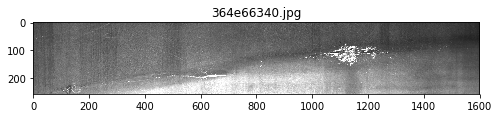

The images pixel resolution is (1600, 256)


In [13]:
# Sample Image
fig, ax = plt.subplots(1,1,figsize=(8, 7))
img = Image.open(str(TRAIN_PATH + X_train.ImageId.iloc[15]))
plt.imshow(img)
ax.set_title(X_train.ImageId.iloc[0])
plt.show()
print("The images pixel resolution is",img.size)

### Exploratory Data Analysis:  Data 

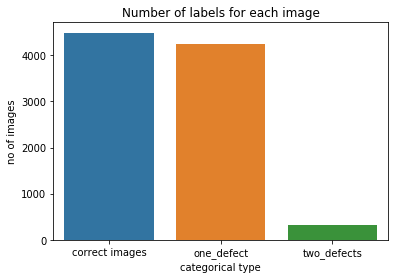

No. of Images with no defects: 4249, with only one defect: 4487, with two defects: 312


In [14]:
tmp = [sum(X_train['hasDefect_1']==1),
       sum(X_train['hasDefect_2']==1),
       sum(X_train['hasDefect_3']==1),
       sum(X_train['hasDefect_4']==1)]

tmp = (X_train['hasDefect_1']+X_train['hasDefect_2']+X_train['hasDefect_3']+X_train['hasDefect_4']).value_counts()
fig, ax = plt.subplots()
sns.barplot(x=['correct images','one_defect','two_defects'],y=tmp)
ax.set_title("Number of labels for each image")
ax.set_xlabel("categorical type")
ax.set_ylabel("no of images")
plt.show()
print("No. of Images with no defects: {}, with only one defect: {}, with two defects: {}".format(tmp[0],tmp[1],tmp[2]))

##### Conclusions:
Almost half of images doesn't contain any defects;

Most of images with defects contain the defects of only one type;

In rare cases an image contains the defects of two different types.

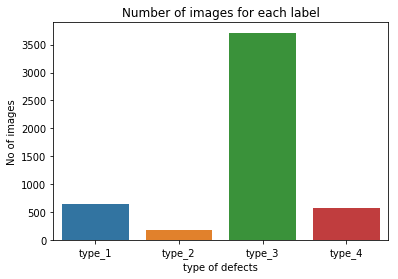

No. of Images having: Label 1 = 645, Label 2 = 178, Label 3 = 3712, Label 4 = 576 
 --------------------------------------------------


In [15]:
tmp = [sum(X_train['hasDefect_1']==1),
       sum(X_train['hasDefect_2']==1),
       sum(X_train['hasDefect_3']==1),
       sum(X_train['hasDefect_4']==1)]
fig, ax = plt.subplots()
#sns.barplot(x=['1','2','3','4'],y=tmp)
sns.barplot(x=['type_1','type_2','type_3','type_4'],y=tmp)
ax.set_title("Number of images for each label")
ax.set_xlabel("type of defects")
ax.set_ylabel("No of images")
plt.show()
print("No. of Images having: Label 1 = {}, Label 2 = {}, Label 3 = {}, Label 4 = {}".format(tmp[0],tmp[1],tmp[2],tmp[3]),'\n','-'*50)


## Conclusions:

The dataset is very imbalanced.  

Data augmentation and resampling techniques will be required to perform the defect detection.

##### Samples with defects and no defect images 

Sample images with  defects:


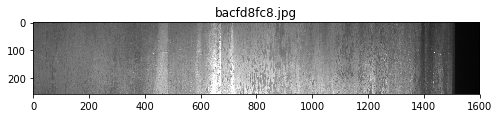

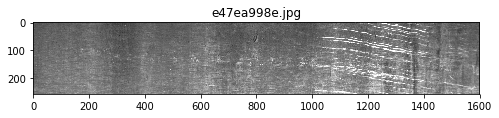

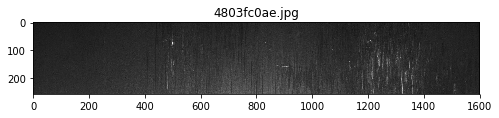

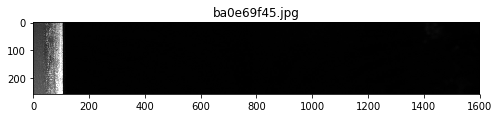

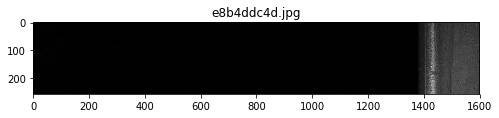

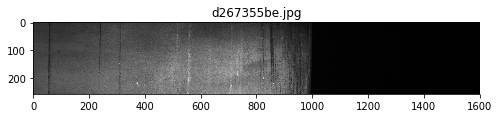

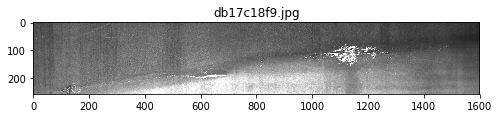

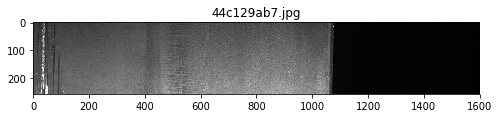

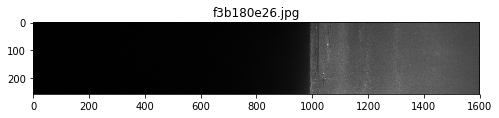

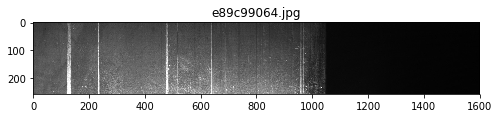

In [16]:
# 5 images having no defects
tmp = []
cnt=0
print("Sample images with  defects:")
for i in X_train['ImageId'][X_train['hasDefect']==1]:
    if cnt<10:
        fig, ax = plt.subplots(1,1,figsize=(8, 7))
        img = Image.open(str(TRAIN_PATH + i))
        plt.imshow(img)
        ax.set_title(i)
        plt.show()
        cnt+=1

Sample images with no defects:


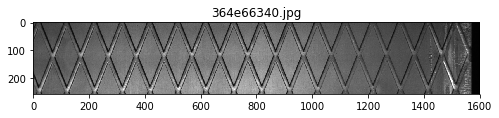

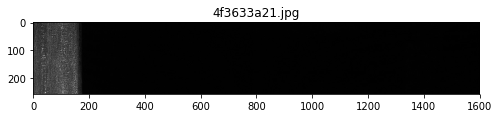

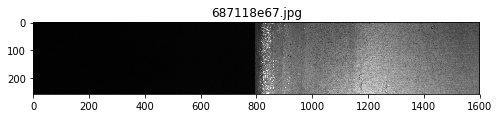

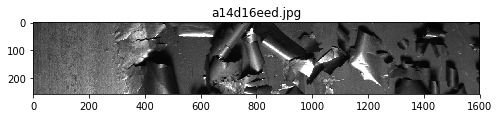

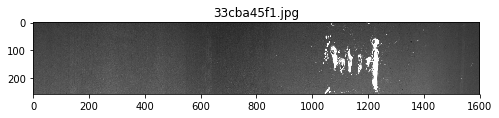

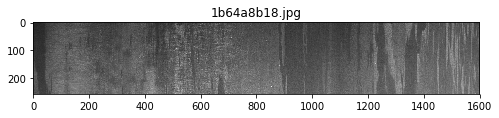

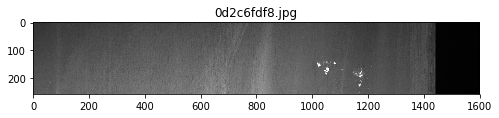

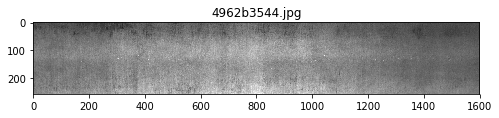

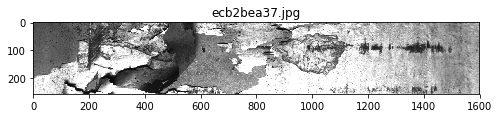

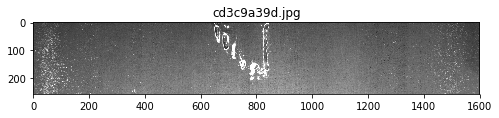

In [17]:
# 5 images having no defects
tmp = []
cnt=0
print("Sample images with no defects:")
for i in X_train['ImageId'][X_train['hasDefect']==0]:
    if cnt<10:
        fig, ax = plt.subplots(1,1,figsize=(8, 7))
        img = Image.open(str(TRAIN_PATH + i))
        plt.imshow(img)
        ax.set_title(i)
        plt.show()
        cnt+=1


The surface of the non-defective steel may contain different features or profile. It has to be noted that that presence of defect is limited to the 4 types of defects in this dataset. The steel surface may contain other defects but those should not be detected.

In [18]:
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

#### Segementation
With the help of image segmentation we can partition the image into multiple segments. This will make it easy for the computer to learn from patterns in these multiple segments. For example, each pixel belonging damage or crack on the steel sheet is coloured yellow.

Sample images with Class 1 defect:


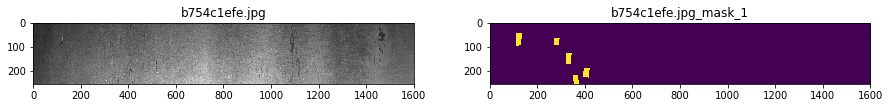

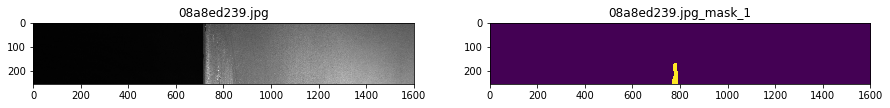

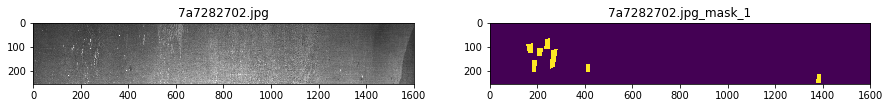

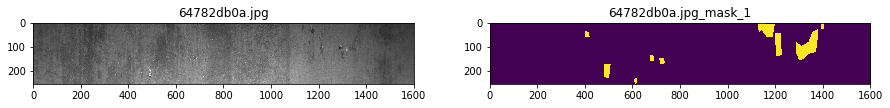

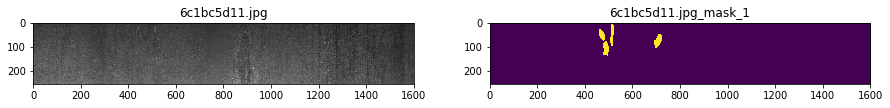

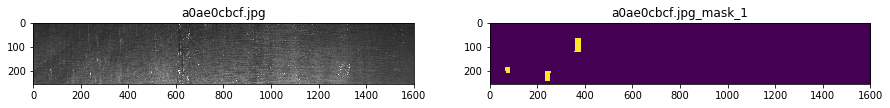

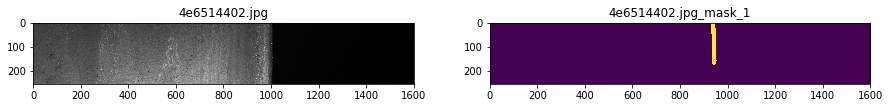

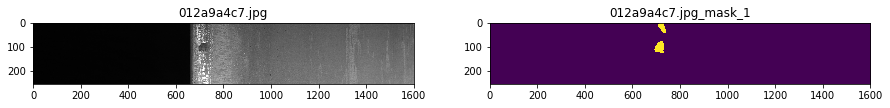

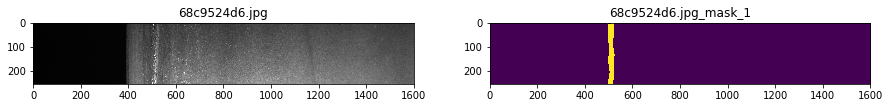

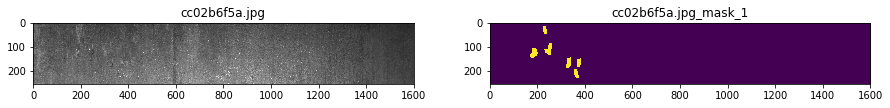

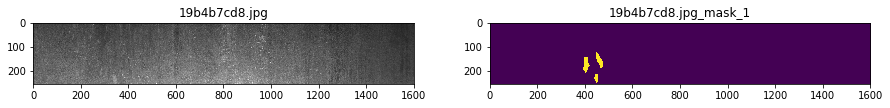

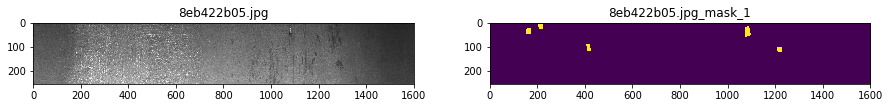

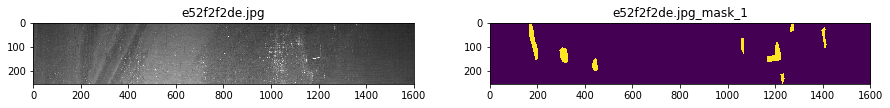

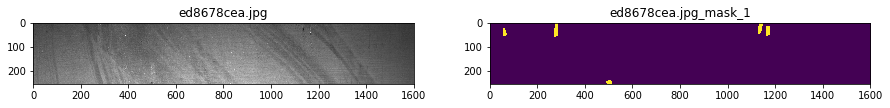

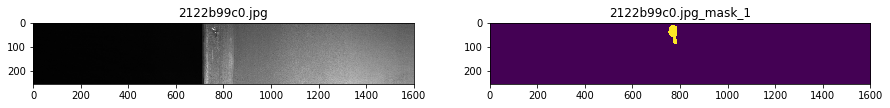

--------------------------------------------------------------------------------
Sample images with Class 2 defect:


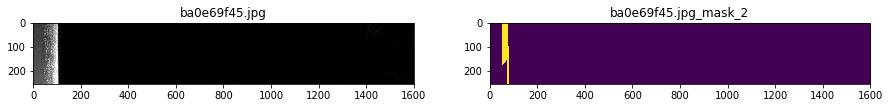

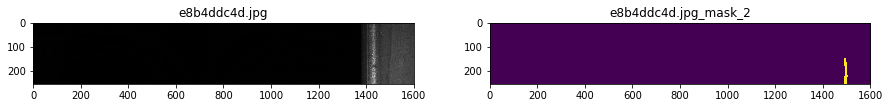

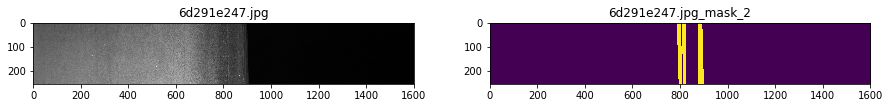

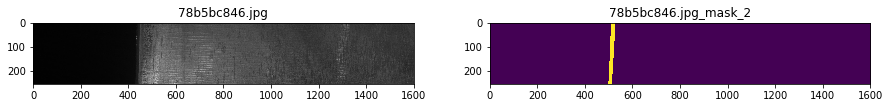

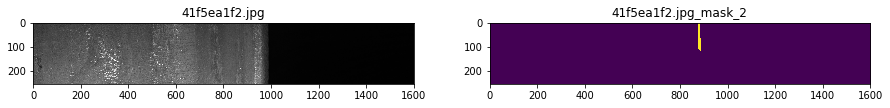

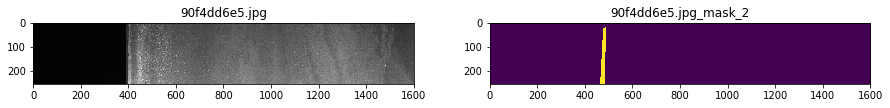

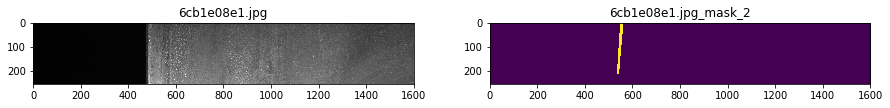

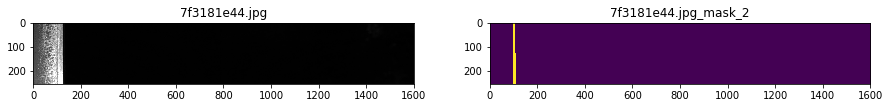

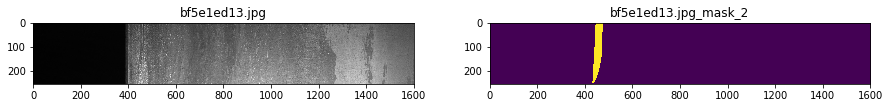

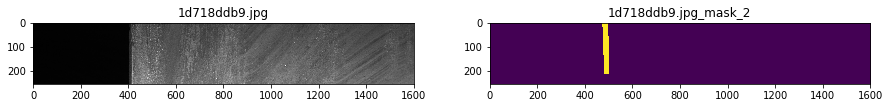

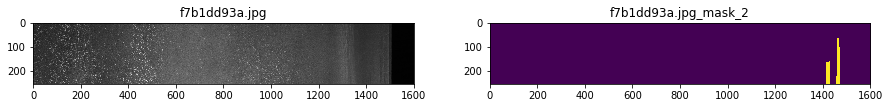

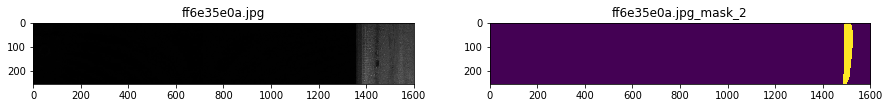

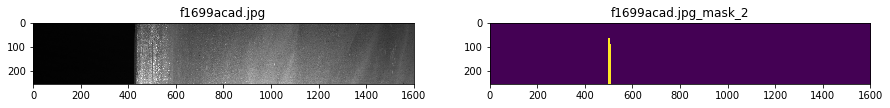

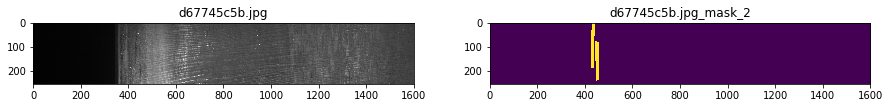

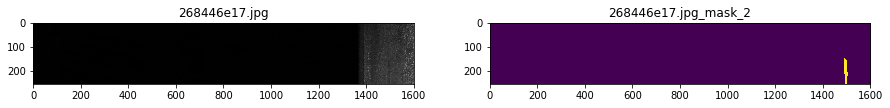

--------------------------------------------------------------------------------
Sample images with Class 3 defect:


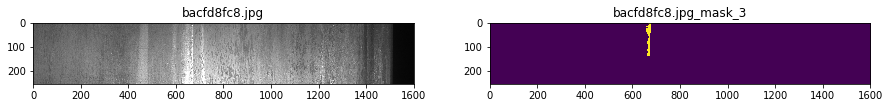

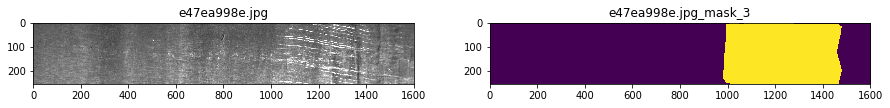

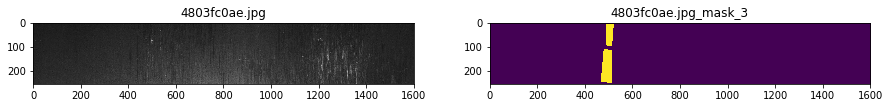

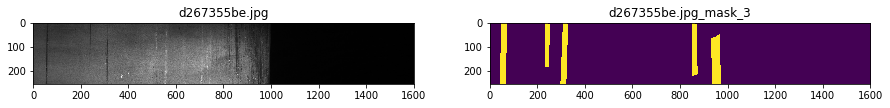

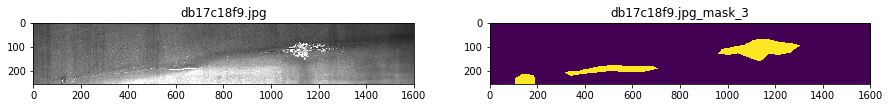

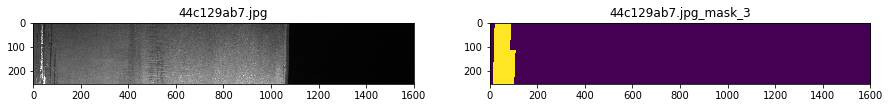

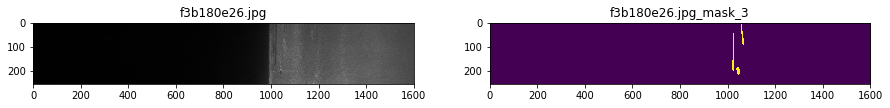

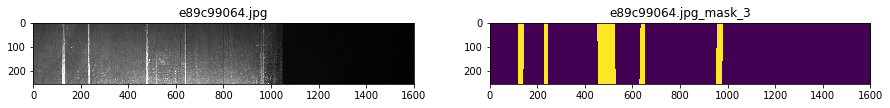

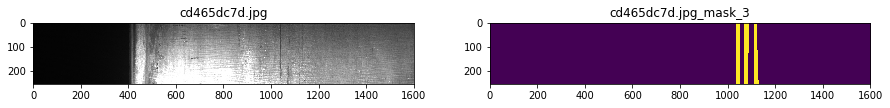

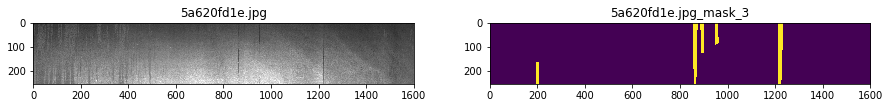

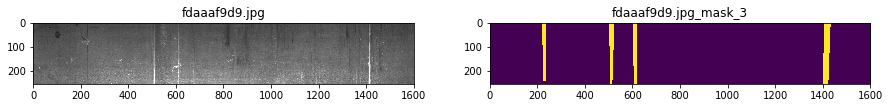

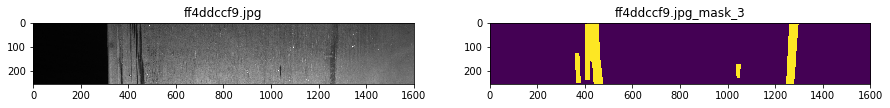

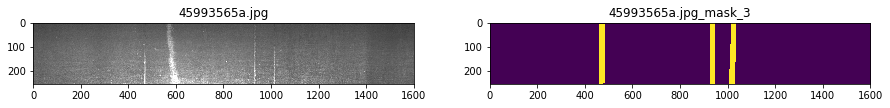

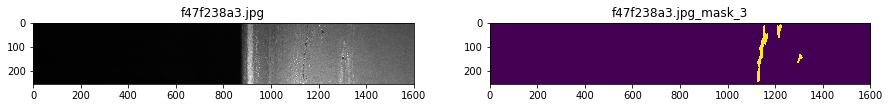

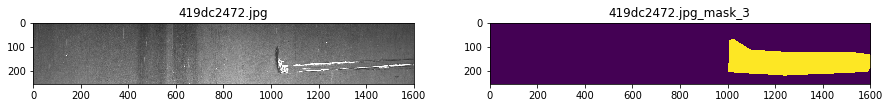

--------------------------------------------------------------------------------
Sample images with Class 4 defect:


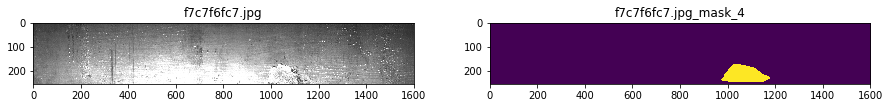

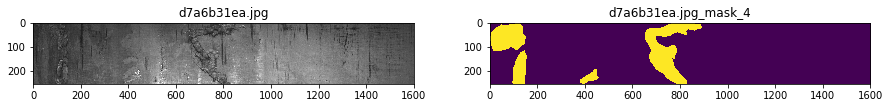

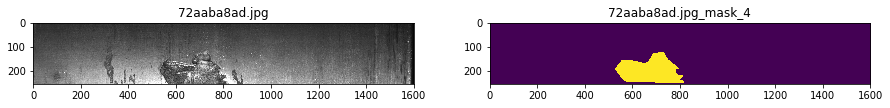

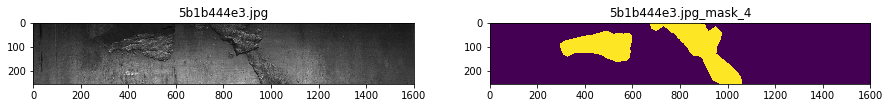

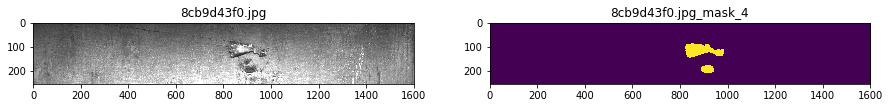

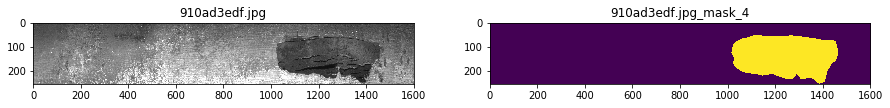

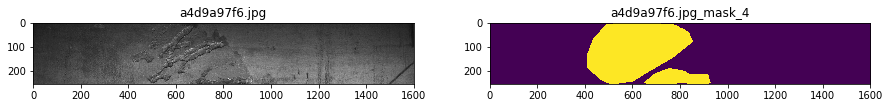

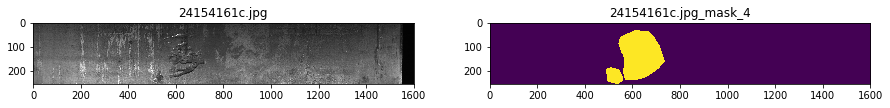

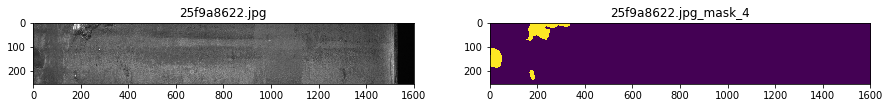

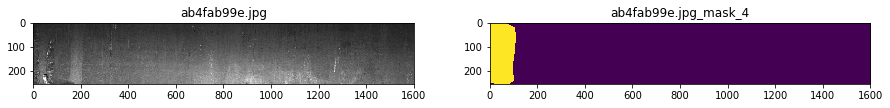

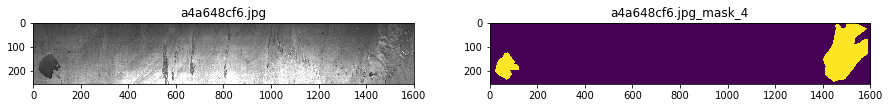

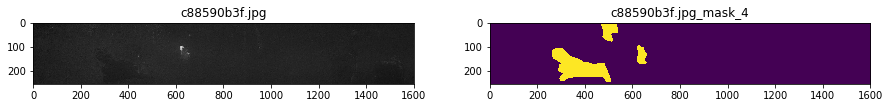

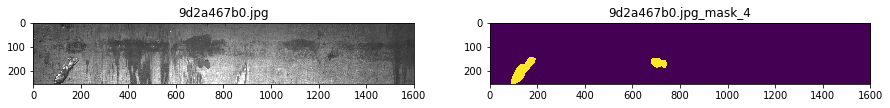

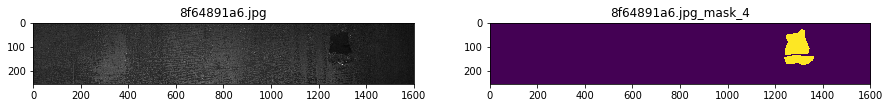

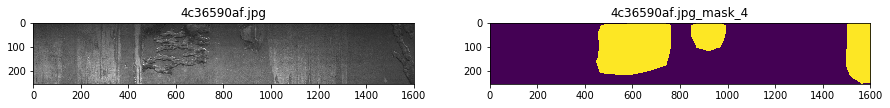

--------------------------------------------------------------------------------


In [19]:
# Visualization: Sample images having defect
for k in [1,2,3,4]:
    tmp = []
    cnt=0
    print("Sample images with Class {} defect:".format(k))
    for i in X_train[X_train[f'hasDefect_{k}']==1][['ImageId',f'Defect_{k}']].values:
        if cnt<15:
            fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(15, 7))
            img = Image.open(str(TRAIN_PATH + i[0]))
            ax1.imshow(img)
            ax1.set_title(i[0])
            cnt+=1
            ax2.imshow(rle2mask(i[1]))
            ax2.set_title(i[0]+'_mask_'+str(k))
            plt.show()
    print('-'*80)

#### Observation:
The regional profile on the masks of defect conataining steel surfaces can be seen to be indistinguishable among different classes. Though defect type 1 can be seen to have multiplte small size regions and defect type 4 images have multiple regions of medium size. Defect type 3 images can be seen to also contain multiple regions of medium size. While defect type 2 and type 3 images can be seen to share some regional characteristics.

'area' as a new feature  
Used for thresholding masks after generating predictions

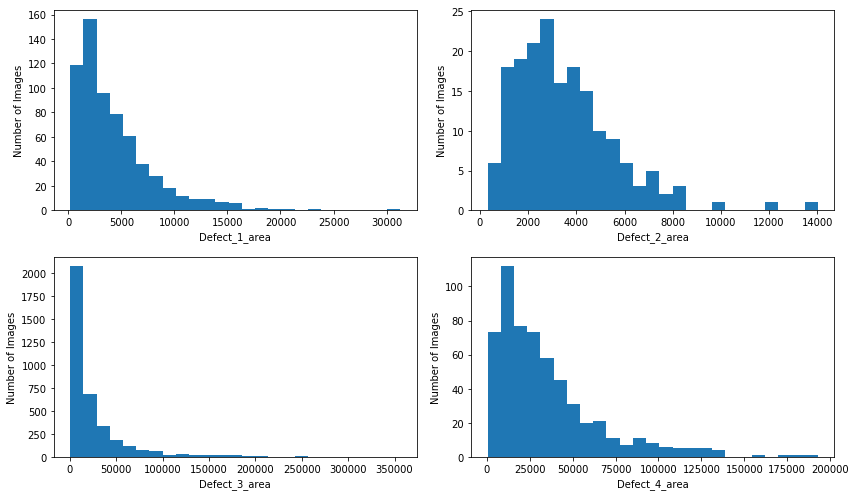

--------------------------------------------------


count          mean           std    min       25%      50%  \
Defect_1   645.0   4350.477519   3733.559124  163.0   1713.00   3243.0   
Defect_2   178.0   3513.308989   2129.522333  316.0   2026.25   3086.0   
Defect_3  3712.0  25593.268858  37296.152095  150.0   5044.50  12151.0   
Defect_4   576.0  34795.451389  30578.036951  491.0  13248.00  25351.5   

               75%       max  
Defect_1   5773.00   31303.0  
Defect_2   4611.75   14023.0  
Defect_3  29399.00  356308.0  
Defect_4  45025.25  192780.0

In [20]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(12,7))

tmp = X_train['Defect_1'][X_train['hasDefect_1']==1].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]]))
ax1.hist(tmp.values,bins = 25)
ax1.set_xlabel('Defect_1_area')
ax1.set_ylabel('Number of Images')


tmp = X_train['Defect_2'][X_train['hasDefect_2']==1].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]]))
ax2.hist(tmp.values,bins = 25)
ax2.set_xlabel('Defect_2_area')
ax2.set_ylabel('Number of Images')


tmp = X_train['Defect_3'][X_train['hasDefect_3']==1].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]]))
ax3.hist(tmp.values,bins = 25)
ax3.set_xlabel('Defect_3_area')
ax3.set_ylabel('Number of Images')


tmp = X_train['Defect_4'][X_train['hasDefect_4']==1].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]]))
ax4.hist(tmp.values,bins = 25)
ax4.set_xlabel('Defect_4_area')
ax4.set_ylabel('Number of Images')
plt.tight_layout()
plt.show()
print('-'*50)



tmp =[]
for i in [1,2,3,4]:

    tmp.append(X_train[f'Defect_{i}'][X_train[f'hasDefect_{i}']==1].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]])).describe())
area_df = pd.DataFrame(tmp)
area_df.index=['Defect_1','Defect_2','Defect_3','Defect_4']
area_df

There is considerable overlap in the range of area. Minimum area for each defect type can be seen closer to each other. While the maximum is largely different. We can use the minimum and maximum values of area in training images to threshold test image defect predictions

In [21]:
# removing areas below 2 percentile and above 98 percentile to threshold area of predicted masks
tmp = []
for i in [1,2,3,4]:
    tmp_1 = X_train[f'Defect_{i}'][X_train[f'hasDefect_{i}']==1].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]])).sort_values().reset_index().drop('index',axis=1)
    tmp.append([tmp_1.iloc[int(0.02*len(tmp_1))].values[0],tmp_1.iloc[-int(0.02*len(tmp_1))].values[0]])
print('Limiting area to above 2 percentile and below 98 percentile values: \n',tmp)

Limiting area to above 2 percentile and below 98 percentile values: 
 [[525, 15305], [751, 9641], [1146, 160085], [2882, 126754]]


In [22]:
area_threshold = pd.DataFrame([[500,15500],[700,10000],[1100,160000],[2800,127000]],
                               columns=['min','max'], index=['defect_1','defect_2','defect_3','defect_4'])
area_threshold # to threshold predictions

min     max
defect_1   500   15500
defect_2   700   10000
defect_3  1100  160000
defect_4  2800  127000

#### EDA conclusion:
a) The dataset is imbalanced thus we will use stratified sampling for splitting the dataset into train and validation datasets.

b) This is a multi-label image segmentation problem. As there are around 50% of images with no defects, it is equally important to identify images with no defects.

c) Based on area thresholds from 'test_thresolds' dataframe and class probability thresholds (which are to be determined after predictions from neural networks), we will ensure that number of predicted images per defect will be closer to the values in 'count' column.

d) Procedure:

We will have a binary classification model to filter images with defects from no defect images.
A 4-label classification model to predict probablities of images beloning to each class.
4 segmentation models for four different classes to generate masks for each test image.
Convert masks to EncodedPixels and filter them as per classification probabilities.
e) We are generating a new solution to the business problem with available libraries: tensorflow, keras and segmentation_models.


### Data preparation and Model Building

In [23]:
train_segmentation = True
train_classification_binary = True
train_classification_multi = True
epochs = 30

In [24]:
def dice_coef(y_true, y_pred, smooth=K.epsilon()):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))      
    recall = true_positives / (possible_positives + K.epsilon())   
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))         
    precision = true_positives /(predicted_positives + K.epsilon()) 
    return precision
    
def f1_score_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)  
    recall = recall_m(y_true, y_pred)        
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

dependencies = {
    'recall_m':recall_m,
    'precision_m':precision_m,
    'dice_coef':dice_coef,
    'f1_score_m':f1_score_m,
    'dice_loss':sm.losses.dice_loss
}

### Binary Classification
Train and predict the probability of presence of defects in images.

In [25]:
X_train_binary = X_train[['ImageId','hasDefect']]
X_val_binary = X_val[['ImageId','hasDefect']]
X_test_binary = X_test[['ImageId','hasDefect']]

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_binary.shape, X_val_binary.shape, X_test_binary.shape)

(9048, 11) (2263, 11) (1257, 11)
(9048, 2) (2263, 2) (1257, 2)


##### Data Agumentation
ImageDataGenerator which allows to quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors.

In [34]:
train_DataGenerator_1 = ImageDataGenerator(rescale=1./255., shear_range=0.2, zoom_range=0.05, rotation_range=5,
                           width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, vertical_flip=True)

test_DataGenerator_1 = ImageDataGenerator(rescale=1./255)

train_generator = train_DataGenerator_1.flow_from_dataframe(
        dataframe=X_train_binary.astype(str),
        directory=TRAIN_PATH,
        x_col="ImageId",
        y_col="hasDefect",
        target_size=(100,200),
        batch_size=128,
        class_mode='binary')

validation_generator = test_DataGenerator_1.flow_from_dataframe(
        dataframe=X_val_binary.astype(str),
        directory=TRAIN_PATH,
        x_col="ImageId",
        y_col="hasDefect",
        target_size=(100,200),
        batch_size=128,
        class_mode='binary')

Found 9048 validated image filenames belonging to 2 classes.
Found 2263 validated image filenames belonging to 2 classes.


In [35]:
base_model = tensorflow.keras.applications.xception.Xception(include_top = False, input_shape = (100,200,3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
 
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)

# and the prediction layer
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 200, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 99, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 99, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 99, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [36]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy',metrics=['acc',f1_score_m,precision_m,recall_m])
history = model.fit_generator(train_generator,validation_data = validation_generator,epochs =1, verbose=1,)
 

71/71 [==============================] - 6856s 97s/step - loss: 0.5432 - acc: 0.7206 - f1_score_m: 0.7459 - precision_m: 0.7212 - recall_m: 0.7762 - val_loss: 0.6187 - val_acc: 0.6288 - val_f1_score_m: 0.5279 - val_precision_m: 0.8178 - val_recall_m: 0.3914


In [37]:
history1 = model.fit_generator(train_generator,validation_data = validation_generator,epochs =5, verbose=1,)

Epoch 1/5
71/71 [==============================] - 17458s 246s/step - loss: 0.3706 - acc: 0.8260 - f1_score_m: 0.8349 - precision_m: 0.8388 - recall_m: 0.8360 - val_loss: 0.4997 - val_acc: 0.7494 - val_f1_score_m: 0.7059 - val_precision_m: 0.9239 - val_recall_m: 0.5734
Epoch 2/5
71/71 [==============================] - 11381s 160s/step - loss: 0.3028 - acc: 0.8645 - f1_score_m: 0.8722 - precision_m: 0.8714 - recall_m: 0.8763 - val_loss: 0.3709 - val_acc: 0.8396 - val_f1_score_m: 0.8332 - val_precision_m: 0.9281 - val_recall_m: 0.7575
Epoch 3/5
71/71 [==============================] - 3726s 52s/step - loss: 0.2684 - acc: 0.8846 - f1_score_m: 0.8906 - precision_m: 0.8954 - recall_m: 0.8882 - val_loss: 0.2925 - val_acc: 0.8630 - val_f1_score_m: 0.8770 - val_precision_m: 0.8338 - val_recall_m: 0.9262
Epoch 4/5
71/71 [==============================] - 3687s 52s/step - loss: 0.2406 - acc: 0.8974 - f1_score_m: 0.9031 - precision_m: 0.9060 - recall_m: 0.9026 - val_loss: 0.2818 - val_acc: 0.882

In [38]:
#model.save()
from tensorflow.keras.models import load_model
model.save('binary_class.h5')

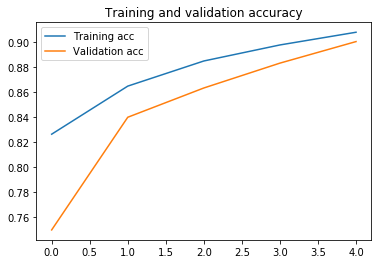

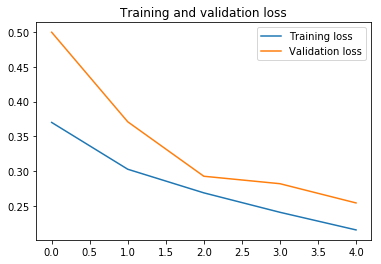

In [41]:
import matplotlib.pyplot as plt

acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Binary classifciation has perforemed very well with the accuracy 90%  by using Keras xception application. 
